# Simulating Best Ball Mania Drafts Using Realistic Market Dynamics

## Tim Bryan

[@timbryan000](https://www.twitter.com/timbryan000)

>"I believe the market accurately reflects not the truth, which is what the efficient market hypothesis says, but it accurately and efficiently reflects everybody's opinion as to what's true." - Howard Marks

When it comes to modeling anything with an underlying market - stocks, commodities, sports - there are two different approaches. The first, fundamental, is where you build a model based on the underlying data of the system. In the case of fantasy football, a fundamental model might tackle player projections, strength of schedule, bye week analysis. The method I'll be using in this post is __technical modeling__. We'll only be using the movement of the market to find an optimal draft strategy. At the end you'll have a great understanding of how to pair this technical modeling strategy with your player projections and I'll give you the tools to simulate thousands of drafts quickly.

In [1]:
# Basic Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preparation
Let's create a function for loading our data - the structure of 2021 and 2022 are a little different so we'll handle for that and then combine the DataFrames.

In [2]:
def load_year_data(year):
    """
    Load the Best Ball data into a DataFrame, handles 2021 and 2022 differences in file structure
    """
    df = []
    # Determine the subdirectory based on the year
    subdir = '' if year == 2021 else '/fast'

    # Load regular season data
    for file in os.listdir(f'../data/{year}/regular_season{subdir}'):
        df.append(pd.read_csv(f'../data/{year}/regular_season{subdir}/{file}'))
    df = pd.concat(df, ignore_index=True)

    # Determine how to load post season data based on the year
    post_season_loaders = {'qf': [], 'sf': None, 'f': None}
    if year == 2021:
        post_season_loaders['qf'].append(pd.read_csv(
            f'../data/{year}/post_season/quarterfinals.csv'))
        post_season_loaders['sf'] = pd.read_csv(
            f'../data/{year}/post_season/semifinals.csv')
        post_season_loaders['f'] = pd.read_csv(
            f'../data/{year}/post_season/finals.csv')
    else:
        for file in os.listdir(f'../data/{year}/post_season/quarterfinals/'):
            post_season_loaders['qf'].append(pd.read_csv(
                f'../data/{year}/post_season/quarterfinals/{file}'))
        post_season_loaders['sf'] = pd.read_csv(
            f'../data/{year}/post_season/semifinals/part_00.csv')
        post_season_loaders['f'] = pd.read_csv(
            f'../data/{year}/post_season/finals/part_00.csv')

    post_season_loaders['qf'] = pd.concat(
        post_season_loaders['qf'], ignore_index=True)

    # Convert playoff dataframes to dictionaries and map onto df
    for k, playoffs_df in post_season_loaders.items():
        playoffs_dict = dict(
            zip(playoffs_df['tournament_entry_id'], [1]*len(playoffs_df)))
        df[k] = df['tournament_entry_id'].map(
            playoffs_dict).fillna(0).astype(int)

    # Add a column for the year
    df['year'] = year

    return df

In [3]:
df21 = load_year_data(2021)
df22 = load_year_data(2022)

In [4]:
# Combine the dataframes
df = pd.concat([df21, df22], ignore_index=True)

In [5]:
# Drop columns that are not needed
df = df.drop(columns=['draft_entry_id', 'tournament_round_draft_entry_id'])

In [6]:
df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,qf,sf,f,year
0,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,e762e1de-c639-431b-bbb6-1e30ee9e291f,1,Cam Akers,RB,11,12.14,10,15,2,0.00,1675.10,0,0,0,0,2021
1,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,5e1f4e64-41fa-47ab-8c4b-5562fd1e9eb0,1,Brandin Cooks,WR,10,91.48,5,92,8,103.60,1554.92,0,0,0,0,2021
2,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,f33b8689-4157-409d-950a-0b12244954e2,1,Noah Fant,TE,11,100.64,6,102,9,72.30,1656.58,0,0,0,0,2021
3,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,aeba7ded-dfeb-4b96-bc59-501c4ca29202,1,Matt Ryan,QB,6,138.23,8,152,13,97.56,1732.12,1,1,0,0,2021
4,64c5c57f-dfe6-49b7-a0c2-180a8e8e2ad9,2021-07-20 05:54:15.422561+00:00,30,072a49a9-bc24-4176-b09b-e053fc9f05eb,1,A.J. Brown,WR,13,23.25,2,23,2,103.50,1614.82,0,0,0,0,2021


## Define Player Rankings

In order to model the market, we first need to define the market. We will use __Average Draft Position (ADP)__ as our method for pricing players. I'll be using the earliest 2022 ADP rankings, but for the simulations coming up you really use any ranking system as long as it's in the format of the player_rankings DataFrame.

In [7]:
# Filter down to just 2022
df = df[df['year'] == 2022]

In [8]:
# Change draft_time to datetime
df['draft_time'] = pd.to_datetime(df['draft_time'], utc=True)

# Locate the first draft time for each player
mask = df.groupby(['player_name'])['draft_time'].transform('min') == df['draft_time']

# Filter down to this earliest draft time for each player
player_rankings = df.loc[mask, ['player_name','position_name', 'year', 'projection_adp', 'pick_points']].reset_index(drop=True)

In [9]:
# Drop players where position is FB
player_rankings = player_rankings[player_rankings['position_name'] != 'FB']

# Drop players where adp_projection is 0
player_rankings = player_rankings[player_rankings['projection_adp'] != 0]

In [10]:
player_rankings.sort_values('projection_adp').head(10)

,player_name,position_name,year,projection_adp,pick_points
142,Jonathan Taylor,RB,2022,1.0,125.00
173,Christian McCaffrey,RB,2022,2.0,227.66
203,Cooper Kupp,WR,2022,3.0,162.50
170,Derrick Henry,RB,2022,4.0,214.36
143,Ja'Marr Chase,WR,2022,5.0,154.90
132,Austin Ekeler,RB,2022,6.0,246.20
47,Justin Jefferson,WR,2022,7.0,247.26
229,Najee Harris,RB,2022,8.0,130.56
78,Tyreek Hill,WR,2022,9.0,236.70
44,Davante Adams,WR,2022,10.0,236.90


## Gathering Market Dynamics

Next, let's gather market dynamics from the Underdog Fantasy datasets. The market dyamics we'll be using are how people are drafting relative to ADP. We're calling this __market delta__ and it's simply the ADP minus the overall pick number. Some players employ a 0 RB strategy, others will "reach" relative to the market to secure a top QB - there's lots of different strategies and we can simulate them all.

In [11]:
# Define the positions
positions = ['QB', 'RB', 'TE', 'WR']

In [12]:
# Create a column for delta from ADP
df['market_delta'] = df['projection_adp'] - df['overall_pick_number']

# Create a column for delta from ADP by position
for pos in positions:
    df['market_delta_' +
        pos] = np.where(df['position_name'] == pos, df['market_delta'], 0)

In [13]:
# Drop the columns we don't need
market_dynamics_df = df.drop(columns=['draft_time', 'tournament_round_number',
                                      'player_name', 'position_name', 'bye_week',
                                      'projection_adp', 'overall_pick_number',
                                      'qf', 'sf', 'f', 'year', 'clock', 'market_delta'])

In [14]:
# Add columns for market delta and standard deviation thereof by position
market_dynamics_df = market_dynamics_df.groupby('tournament_entry_id').agg({
    'market_delta_QB': ['mean', 'std'],
    'market_delta_RB': ['mean', 'std'],
    'market_delta_TE': ['mean', 'std'],
    'market_delta_WR': ['mean', 'std']
})

# Flatten the column names
market_dynamics_df.columns = ['_'.join(col).strip() for col in market_dynamics_df.columns.values]

In [15]:
market_dynamics_df.head()

,market_delta_QB_mean,market_delta_QB_std,market_delta_RB_mean,market_delta_RB_std,market_delta_TE_mean,market_delta_TE_std,market_delta_WR_mean,market_delta_WR_std
tournament_entry_id,,,,,,,,
0000146a-e245-49c3-8a4e-8e739cfe1e46,0.377778,1.259302,5.035000,14.108540,0.021111,2.782994,0.870000,3.350938
0000225d-54fa-4334-aa1e-41e7adaa2542,0.006667,1.790672,-0.147222,2.457519,-0.446111,1.304730,-0.466111,1.952305
00004939-5e99-4dfb-b597-d6463eacf6aa,4.343889,12.045567,0.462222,2.107054,-0.539444,4.492765,-2.013333,4.747164
0000766d-7308-495e-ad86-6ddb69dbc3ab,0.023333,0.925063,-0.858333,4.370150,-0.015556,1.465297,-2.045000,3.523895
00007ef0-3100-479d-be3c-e7263edb4b5b,1.474444,5.236630,-2.068333,4.801088,-0.075000,0.536823,-1.862778,3.800692


Take the first row as an example; we can see this person on average drafted their RBs 5 picks behind ADP, plus or minus 14 picks. This is a high standard deviation, but this person drafted RBs whose ADP was lower than their current pick - they were consistently reaching for RBs relative to the market. Below you'll see that a majority of players draft close to ADP with some tails on either side. Something interesting to note is the larger than normal right tail for RBs. There's so much talk of the 0 RB strategy but it seems the market still reaches for RBs more than other positions.

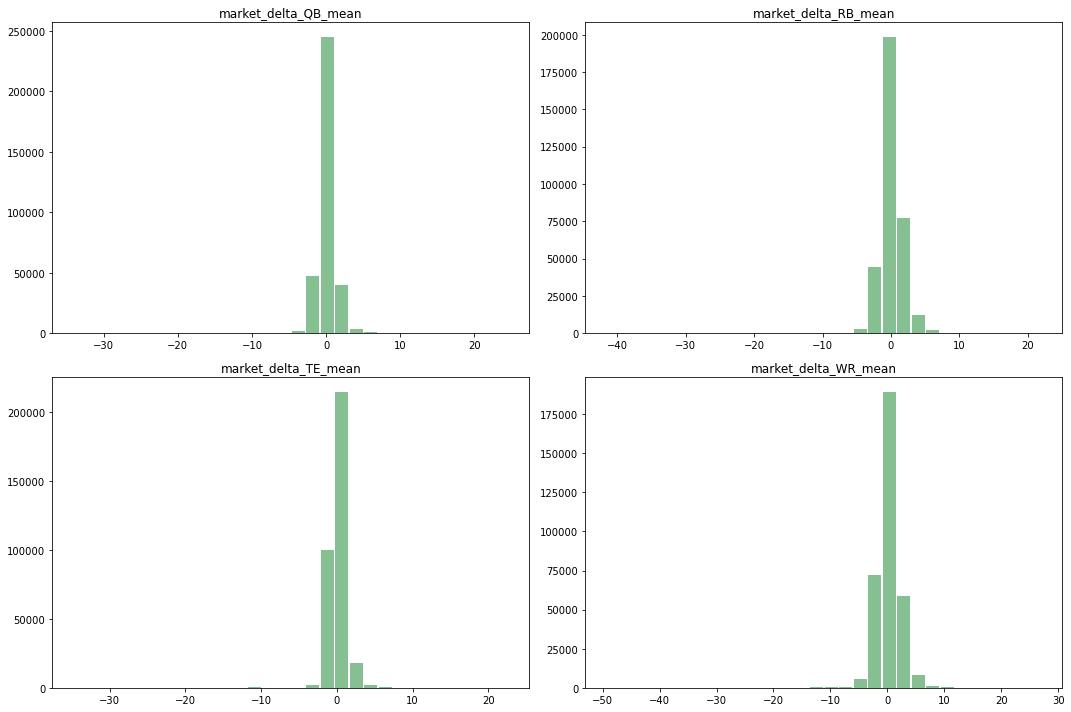

In [16]:
# Select only the mean columns
mean_columns = ['market_delta_QB_mean', 'market_delta_RB_mean',
                'market_delta_TE_mean', 'market_delta_WR_mean']
mean_df = market_dynamics_df[mean_columns]

# Plot histograms
mean_df.hist(bins=30, figsize=(15, 10), grid=False,
             color='#86bf91', zorder=2, rwidth=0.9)

plt.tight_layout()
plt.show()

## Draft Simulator
Below you'll see two different classes. The first is a strategy generator, which will allow us to load the market dynamics strategy of any of these Best Ball strategies OR even our own custom strategy. The second is a very complex draft simulator class. You can review the code yourself but I'll explain in simple terms what it does:

1. Initializes 12 teams with the standard rosters of Best Ball Mania (QB1, RB1, RB2, WR1, WR2, WR3, TE1, FLEX, BENCH x 10)
2. If no strategy is loaded, by default each team will select the player that has the lowest ADP and is available
3. If a strategy is loaded for the team, it will calculate __adjusted ADP__ based on a normal distribution of the mean market delta and standad deviation for each position. For example, if we set a team's market delta for QB to +5 plus or minus 1 then the adjusted ADP for Josh Allen may go from 19 to 12. The simulation then selects the player with the lowest available adjusted ADP.
4. For each pick, the simulation is checking if the number of required roster slots is equal to the number of picks remaining. If this is the case, then the sim will select the lowest available ADP or adjusted ADP to fill those slots.
5. Reorder the players so the highest scoring players are in the starting slots. I realize Best Ball rosters are reordered every week, but this is a close approximation.

It's not a perfect representation of how a market works, but it gives us an idea of how the flow of a draft can go depending on how you set the teams' valuation of different positions. As a reminder, a positive market delta means the team is willing to wait on that position, a negative market delta means the team will reach for that position.

In [17]:
class StrategyGenerator:
    def __init__(self, num_teams):
        self.num_teams = num_teams

    def generate(self, strategy_dict=None):
        if strategy_dict is None:
            strategy_dict = {}

        strategies = {i: None for i in range(self.num_teams)}
        strategies.update(strategy_dict)

        return strategies

In [18]:
class DraftSimulator:
    def __init__(self, available_players: pd.DataFrame, strategies: dict):
        self.available_players = available_players.copy()
        self.strategies = strategies
        self.team_rosters = {i: {'QB1': None, 'RB1': None, 'RB2': None, 'WR1': None, 'WR2': None, 'WR3': None,
                                 'TE1': None, 'FLEX': None, 'BENCH': []} for i in range(12)}

        # Create snake draft order
        self.draft_order = []
        for i in range(20):  # 20 rounds
            round_order = list(range(12)) if i % 2 == 0 else list(
                range(11, -1, -1))  # Reverse order every other round
            self.draft_order.extend(round_order)

    def _calculate_adjusted_projection_adp(self, player, strategy):
        if strategy and player['position_name'] in strategy:
            mean_market_delta = strategy[player['position_name']]['mean']
            stddev_market_delta = strategy[player['position_name']]['stddev']
            return np.random.normal(loc=player['projection_adp'] - mean_market_delta, scale=stddev_market_delta)
        return player['projection_adp']

    def _best_available_player(self, team_number, remaining_picks):
        # Calculate adjusted_projection_adp for all available players first
        self.available_players['adjusted_projection_adp'] = self.available_players.apply(
            self._calculate_adjusted_projection_adp, axis=1, args=(self.strategies.get(team_number),))

        # If remaining slots equal remaining picks, must draft needed positions
        needed_positions = [pos for pos, player in self.team_rosters[team_number].items(
        ) if player is None and pos != 'BENCH']
        if len(needed_positions) == remaining_picks:
            for position in needed_positions:
                position_players = self.available_players[self.available_players['position_name']
                                                          == position[:-1] if position not in ['FLEX', 'BENCH'] else position]
                if len(position_players) > 0:
                    return position_players.nsmallest(1, 'adjusted_projection_adp').iloc[0]

        # Otherwise, return player with lowest adjusted ADP
        if len(self.available_players) > 0:
            return self.available_players.nsmallest(1, 'adjusted_projection_adp').iloc[0]

        # No players left to draft, throw an exception
        if len(self.available_players) == 0:
            raise Exception('No players left to draft. Check your drafting logic.')

    def _add_to_team(self, team_number, player):
        team = self.team_rosters[team_number]
        position = player['position_name'] + '1'
        slot = None
        if team[position] is None:
            team[position] = player
            slot = position
        elif position[:-1] + '2' in team and team[position[:-1] + '2'] is None:
            team[position[:-1] + '2'] = player
            slot = position[:-1] + '2'
        elif position[:-1] == 'WR' and team['WR3'] is None:
            team['WR3'] = player
            slot = 'WR3'
        elif position[:-1] in ['RB', 'WR', 'TE'] and team['FLEX'] is None:
            team['FLEX'] = player
            slot = 'FLEX'
        else:
            team['BENCH'].append(player)
            slot = 'BENCH'

        self.available_players.drop(player.name, inplace=True)
        return slot

    def simulate_draft(self):
        results = []
        for i, team_number in enumerate(self.draft_order):
            remaining_picks = len(self.draft_order) - i
            player = self._best_available_player(team_number, remaining_picks)
            slot = self._add_to_team(team_number, player)
            result = {
                'player_name': player['player_name'],
                'position_name': player['position_name'],
                'slot': slot,
                'year': player['year'],
                'projection_adp': player['projection_adp'],
                'adjusted_projection_adp': player['adjusted_projection_adp'],
                'team_number': team_number,
                'round_number': i//12 + 1,
                'pick_number': i + 1,
                'pick_points': player['pick_points'],  # add this line
            }
            results.append(result)

        return pd.DataFrame(results)

As a test, I'll just set the strategy of the team picking first. We'll make them a QB happy team, so I'm going to set their QB market delta to 5 and add some variance.

In [38]:
# Example strategy dictionary
example_strategy = {
    'market_delta_QB_mean': 5,
    'market_delta_QB_std': 3,
    'market_delta_RB_mean': 0,
    'market_delta_RB_std': 0,
    'market_delta_TE_mean': 0,
    'market_delta_TE_std': 0,
    'market_delta_WR_mean': 0,
    'market_delta_WR_std': 0
}

# Package the strategy dictionary into a single object
team_strategy = {
    'QB': {'mean': example_strategy['market_delta_QB_mean'], 'stddev': example_strategy['market_delta_QB_std']},
    'RB': {'mean': example_strategy['market_delta_RB_mean'], 'stddev': example_strategy['market_delta_RB_std']},
    'WR': {'mean': example_strategy['market_delta_WR_mean'], 'stddev': example_strategy['market_delta_WR_std']},
    'TE': {'mean': example_strategy['market_delta_TE_mean'], 'stddev': example_strategy['market_delta_TE_std']},
}

In [39]:
# Create strategy dict for all teams (teams without a strategy have None)
strategy_dict = {0: team_strategy}  # Team numbers start at 0

# Generate strategies
generator = StrategyGenerator(num_teams=12)
strategies = generator.generate(strategy_dict)

Now let's simulate the draft and see how our adjustments effect the outcome!

In [40]:
# Build the draft simulator
draft = DraftSimulator(available_players=player_rankings, strategies=strategies)

In [41]:
# Simulate the draft
results = draft.simulate_draft()

As you can see below, our adjustments made the team #0 jump on Patrick Mahomes at the end of the second round. You can imagine how turning the dials on multiple different team strategies and running these sims hundreds or thousands of times would gives us a ton of different outcomes.

In [42]:
results.sort_values(by='pick_number', ascending=True).head(25)

,player_name,position_name,slot,year,projection_adp,adjusted_projection_adp,team_number,round_number,pick_number,pick_points
0,Jonathan Taylor,RB,RB1,2022,1.0,1.000000,0,1,1,125.00
1,Christian McCaffrey,RB,RB1,2022,2.0,2.000000,1,1,2,227.66
2,Cooper Kupp,WR,WR1,2022,3.0,3.000000,2,1,3,162.50
3,Derrick Henry,RB,RB1,2022,4.0,4.000000,3,1,4,214.36
4,Ja'Marr Chase,WR,WR1,2022,5.0,5.000000,4,1,5,154.90
5,Austin Ekeler,RB,RB1,2022,6.0,6.000000,5,1,6,246.20
6,Justin Jefferson,WR,WR1,2022,7.0,7.000000,6,1,7,247.26
7,Najee Harris,RB,RB1,2022,8.0,8.000000,7,1,8,130.56
8,Tyreek Hill,WR,WR1,2022,9.0,9.000000,8,1,9,236.70
9,Davante Adams,WR,WR1,2022,10.0,10.000000,9,1,10,236.90


And here's team #0's full team for reference. You can see they have an absurd amount of QBs, but the logic in the class ensures they are able to fill out a full roster regardless.

In [43]:
results[results['team_number']== 0]

,player_name,position_name,slot,year,projection_adp,adjusted_projection_adp,team_number,round_number,pick_number,pick_points
0,Jonathan Taylor,RB,RB1,2022,1.00,1.000000,0,1,1,125.00
23,Patrick Mahomes,QB,QB1,2022,28.00,21.451329,0,2,24,200.16
24,DK Metcalf,WR,WR1,2022,24.00,24.000000,0,3,25,138.20
47,Joe Burrow,QB,BENCH,2022,50.00,38.691575,0,4,48,266.18
48,Kyler Murray,QB,BENCH,2022,52.00,45.564941,0,5,49,152.42
71,Matthew Stafford,QB,BENCH,2022,81.00,71.962715,0,6,72,84.24
72,Jalen Hurts,QB,BENCH,2022,77.00,68.502247,0,7,73,337.88
95,Kirk Cousins,QB,BENCH,2022,97.00,90.779123,0,8,96,116.40
96,Kenneth Walker,RB,RB2,2022,96.00,96.000000,0,9,97,126.20
119,Melvin Gordon,RB,FLEX,2022,120.00,120.000000,0,10,120,36.20


## Large Scale Simulation
Now let's try out different market dynamic strategies and simulate them on a large scale. To do this we need to package our DraftSimulator() class into a DraftSimulatorManager() class. This will allow us to run N simulations of varying strategies.

In [44]:
class DraftSimulationManager:
    def __init__(self, available_players: pd.DataFrame, strategies: dict):
        self.available_players = available_players
        self.strategies = strategies
        self.team_points = {i: [] for i in range(12)}

    def simulate_draft(self):
        draft_simulator = DraftSimulator(self.available_players.copy(), self.strategies)
        draft_results = draft_simulator.simulate_draft()
        team_points = draft_results.groupby('team_number').apply(lambda x: x[x['slot'] != 'BENCH']['pick_points'].sum())
        for team_number, points in team_points.iteritems():
            self.team_points[team_number].append(points)

    def run_simulations(self, n: int):
        for _ in range(n):
            self.simulate_draft()

    def points_stats_df(self):
        points_stats = {}
        for team_number, points in self.team_points.items():
            points_array = np.array(points)
            points_stats[team_number] = {
                'Median': np.median(points_array),
                'Mean': np.mean(points_array),
                'Q1': np.percentile(points_array, 25),
                'Q2': np.percentile(points_array, 50),
                'Q3': np.percentile(points_array, 75),
                'Max': np.max(points_array)
            }
        points_stats_df = pd.DataFrame(points_stats).T.rename_axis('team_number').reset_index()
        return points_stats_df

To test, we'll just leave our strategy alone and see how a QB happy team performs against ADP strict teams across 10 simulations

In [45]:
simulation_manager = DraftSimulationManager(player_rankings, strategies)
simulation_manager.run_simulations(10)
points_stats_df = simulation_manager.points_stats_df()

As you can see below, team #0's strategy did not pay off. Next, we'll simulate different market dynamics strategies from Best Ball entries.

In [46]:
points_stats_df

,team_number,Median,Mean,Q1,Q2,Q3,Max
0,0,777.96,780.040,762.860,777.96,785.86,873.76
1,1,1183.32,1135.940,1063.320,1183.32,1183.32,1189.52
2,2,864.90,871.140,839.100,864.90,906.30,906.30
3,3,743.86,746.728,743.860,743.86,761.88,807.38
4,4,1038.16,1044.670,1016.360,1038.16,1059.86,1125.36
5,5,1091.76,1063.260,1045.935,1091.76,1091.76,1091.76
6,6,881.86,891.300,881.860,881.86,881.86,976.26
7,7,710.60,677.858,628.745,710.60,710.60,710.60
8,8,1036.44,1025.098,1036.440,1036.44,1036.44,1036.44
9,9,872.74,872.740,872.740,872.74,872.74,872.74


## Simulating Actual Market Dynamics Strategies
This massive sample of different Best Ball entries gives us a quasi-realistic enviornment to simulate in. We can set one strategy as the __dependent variable__ and sample 11 random entries from real Best Ball entries as the __independent variable__ to emulate a real market enviornment.

Let's start by simulating the 0-RB strategy. In this strategy, the person drafting heavily underweights the importance of RBs on the roster.

In [53]:
# Set the 0-RB strategy
zero_rb = {
    'market_delta_QB_mean': 0,
    'market_delta_QB_std': 0,
    'market_delta_RB_mean': -5,
    'market_delta_RB_std': 3,
    'market_delta_TE_mean': 0,
    'market_delta_TE_std': 0,
    'market_delta_WR_mean': 0,
    'market_delta_WR_std': 0
}

# Package the strategy dictionary into a single object
zero_rb_team_strategy = {
    'QB': {'mean': zero_rb['market_delta_QB_mean'], 'stddev': zero_rb['market_delta_QB_std']},
    'RB': {'mean': zero_rb['market_delta_RB_mean'], 'stddev': zero_rb['market_delta_RB_std']},
    'WR': {'mean': zero_rb['market_delta_WR_mean'], 'stddev': zero_rb['market_delta_WR_std']},
    'TE': {'mean': zero_rb['market_delta_TE_mean'], 'stddev': zero_rb['market_delta_TE_std']},
}

# Start the strategy dictionary with the 0-RB strategy for team 0
strategy_dict = {0: zero_rb_team_strategy}

# Sample 11 other strategies from the DataFrame
sampled_strategies = market_dynamics_df.sample(11)

# Add the sampled strategies to the strategy dictionary
for i, (index, row) in enumerate(sampled_strategies.iterrows()):
    strategy = {
        'QB': {'mean': row['market_delta_QB_mean'], 'stddev': row['market_delta_QB_std']},
        'RB': {'mean': row['market_delta_RB_mean'], 'stddev': row['market_delta_RB_std']},
        'WR': {'mean': row['market_delta_WR_mean'], 'stddev': row['market_delta_WR_std']},
        'TE': {'mean': row['market_delta_TE_mean'], 'stddev': row['market_delta_TE_std']}
    }
    strategy_dict[i+1] = strategy

In [54]:
# Build the draft simulator
draft = DraftSimulator(available_players=player_rankings, strategies=strategy_dict)

In [55]:
# Simulate the draft once just to test
results = draft.simulate_draft()

In [56]:
# Look at the first two rounds
results.sort_values('pick_number', ascending=True).head(25)

,player_name,position_name,slot,year,projection_adp,adjusted_projection_adp,team_number,round_number,pick_number,pick_points
0,Cooper Kupp,WR,WR1,2022,3.0,3.000000,0,1,1,162.50
1,Christian McCaffrey,RB,RB1,2022,2.0,-0.171291,1,1,2,227.66
2,Jonathan Taylor,RB,RB1,2022,1.0,-1.431191,2,1,3,125.00
3,Ja'Marr Chase,WR,WR1,2022,5.0,-6.779563,3,1,4,154.90
4,Davante Adams,WR,WR1,2022,10.0,2.428839,4,1,5,236.90
5,Austin Ekeler,RB,RB1,2022,6.0,3.956579,5,1,6,246.20
6,Derrick Henry,RB,RB1,2022,4.0,0.830971,6,1,7,214.36
7,Justin Jefferson,WR,WR1,2022,7.0,7.125439,7,1,8,247.26
8,Tyreek Hill,WR,WR1,2022,9.0,1.165079,8,1,9,236.70
9,Najee Harris,RB,RB1,2022,8.0,4.977175,9,1,10,130.56


In [57]:
# Look at team 0's draft
results[results['team_number'] == 0]

,player_name,position_name,slot,year,projection_adp,adjusted_projection_adp,team_number,round_number,pick_number,pick_points
0,Cooper Kupp,WR,WR1,2022,3.0,3.000000,0,1,1,162.50
23,Mark Andrews,TE,TE1,2022,23.0,23.000000,0,2,24,128.90
24,DK Metcalf,WR,WR2,2022,24.0,24.000000,0,3,25,138.20
47,Amari Cooper,WR,WR3,2022,48.0,48.000000,0,4,48,135.20
48,Joe Burrow,QB,QB1,2022,50.0,50.000000,0,5,49,266.18
71,Aaron Rodgers,QB,BENCH,2022,71.0,71.000000,0,6,72,191.56
72,Dallas Goedert,TE,FLEX,2022,73.0,73.000000,0,7,73,75.20
95,Allen Robinson,WR,BENCH,2022,94.0,94.000000,0,8,96,52.60
96,Kirk Cousins,QB,BENCH,2022,97.0,97.000000,0,9,97,116.40
119,Noah Fant,TE,BENCH,2022,118.0,118.000000,0,10,120,68.70


Now lets run the RB zero strategy across 20 simulations in each draft position and see how we fare.

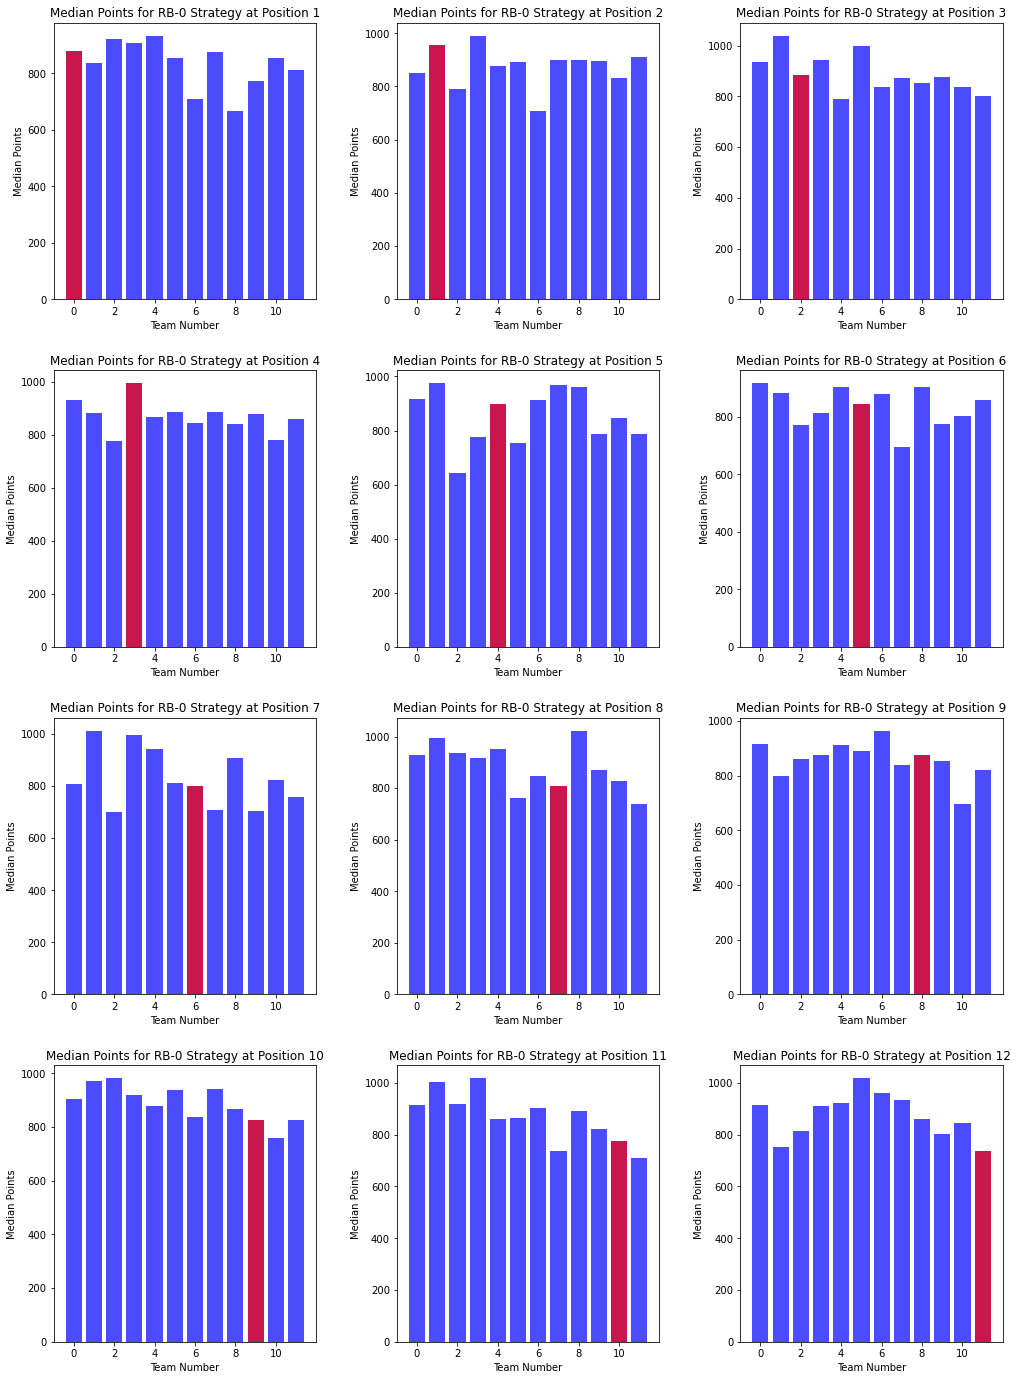

In [61]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.tight_layout(pad=5.0) 

for team_number in range(12):
    # Initialize the strategy dictionary with the 0-RB strategy for the current team
    strategy_dict = {team_number: zero_rb_team_strategy}

    # Sample 11 other strategies from the DataFrame, excluding the current team
    sampled_strategies = market_dynamics_df.sample(11)

    # Add the sampled strategies to the strategy dictionary
    for i, (index, row) in enumerate(sampled_strategies.iterrows()):
        strategy = {
            'QB': {'mean': row['market_delta_QB_mean'], 'stddev': row['market_delta_QB_std']},
            'RB': {'mean': row['market_delta_RB_mean'], 'stddev': row['market_delta_RB_std']},
            'WR': {'mean': row['market_delta_WR_mean'], 'stddev': row['market_delta_WR_std']},
            'TE': {'mean': row['market_delta_TE_mean'], 'stddev': row['market_delta_TE_std']}
        }
        strategy_dict[(i+1)%12] = strategy  # Modulo 12 to ensure team numbers are within 0-11

    # Run the simulations
    sim_manager = DraftSimulationManager(player_rankings.copy(), strategy_dict)
    sim_manager.run_simulations(20)

    # Compute the median points
    points_stats_df = sim_manager.points_stats_df()
    
    # Plot the median points for each team
    ax = axs[team_number // 3, team_number % 3]
    ax.bar(points_stats_df['team_number'], points_stats_df['Median'], color='b', alpha=0.7)
    ax.bar(team_number, points_stats_df.loc[points_stats_df['team_number'] == team_number, 'Median'], color='r', alpha=0.7)
    ax.set_xlabel('Team Number')
    ax.set_ylabel('Median Points')
    ax.set_title(f'Median Points for RB-0 Strategy at Position {team_number+1}')
    
plt.show()

## Conclusion

As you can see, the RB-0 strategy actually fares pretty well across many different draft positions. __This simulation tool is an excellent way to test different draft strategies in a realistic enviornment__. By sampling __actual Best Ball strategies__ and running them against the strategy you'd like to test